In [2]:
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt
import time


In [3]:
rootfolder = '..'

Load the image and rescale it in $[0,1]$

In [4]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255
# img = img[50:200, 50:200]
imsz = img.shape

# patch size
p = 7
if not p%2 == 0:
    p=p-1

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 12


Corrupt the image with white gaussian noise

In [5]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [6]:
mse = np.mean((img-noisy_img)**2)
psnr_noisy = 10*np.log10(1/mse)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.12')

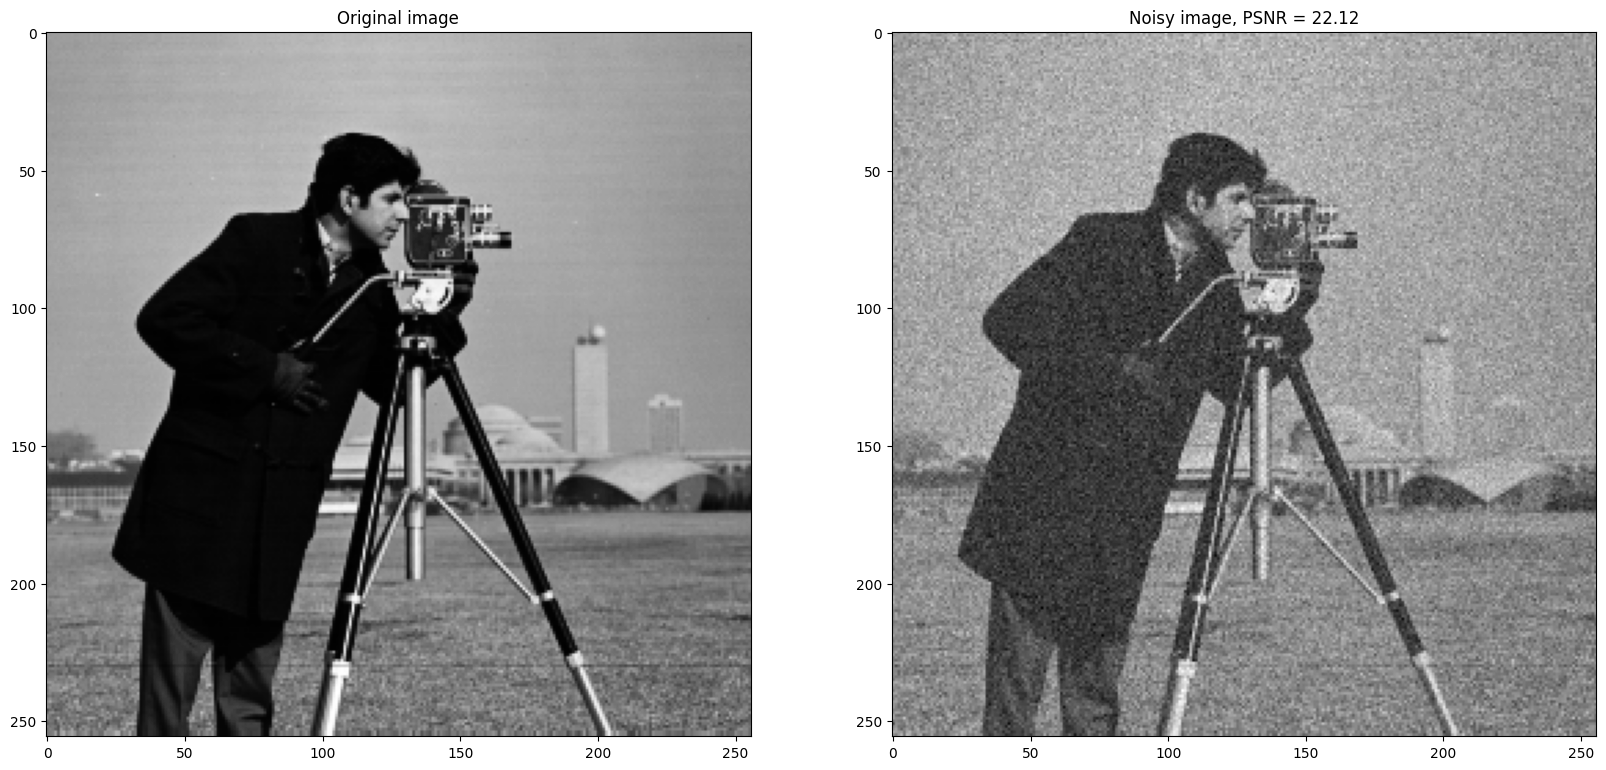

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

In [8]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
h= p//2
img_pad = np.pad(noisy_img, h, 'symmetric')


Main loop

In [9]:
img_pad.shape

(262, 262)

In [10]:
for r in range(0, imsz[0]):
    for c in range(0, imsz[1]):
        # extrach the patch from img_pad whose center has the location (i, j) in the noisy image
        s = img_pad[r:r+p, c:c+p]

        # initialize the pixel estimate and the total weights
        pixel_hat = 0
        weight = 0
        for i in range(-H, H+1):
            for j in range(-H, H+1):
                if (r+i>0 and r+i<=imsz[0] and c+j>0 and c+j<imsz[1]):
                    # extract the patch
                    z = img_pad[r+i:r+i+p, c+j:c+j+p]
                    # print(r+i,':',r+i+h, c+j,':',c+j+h)
                    # print(z)
                    # print()
    
                    # compute the distance with the reference patch
                    d = np.linalg.norm(s - z)**2
    
                    # update the weight and the pixel estimate
                    w = np.exp(-d/(M*(sigma_noise**2)))
                    z_center = z[h,h] # only consider the center of the patch for update
                    pixel_hat += z_center * w 
                    weight += w

        # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
        img_hat[r,c] = pixel_hat/weight

took 14 minutes and 27.9 seconds locally, and 7 minutes and 31 seconds in collab

In [11]:
z

array([[0.65409858, 0.57374377, 0.58446713, 0.49719013, 0.49719013,
        0.58446713],
       [0.32508628, 0.54945683, 0.50329487, 0.47496855, 0.47496855,
        0.50329487],
       [0.47215134, 0.47114165, 0.49944183, 0.49327214, 0.49327214,
        0.49944183],
       [0.47215134, 0.47114165, 0.49944183, 0.49327214, 0.49327214,
        0.49944183],
       [0.32508628, 0.54945683, 0.50329487, 0.47496855, 0.47496855,
        0.50329487],
       [0.65409858, 0.57374377, 0.58446713, 0.49719013, 0.49719013,
        0.58446713]])

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 28.77')

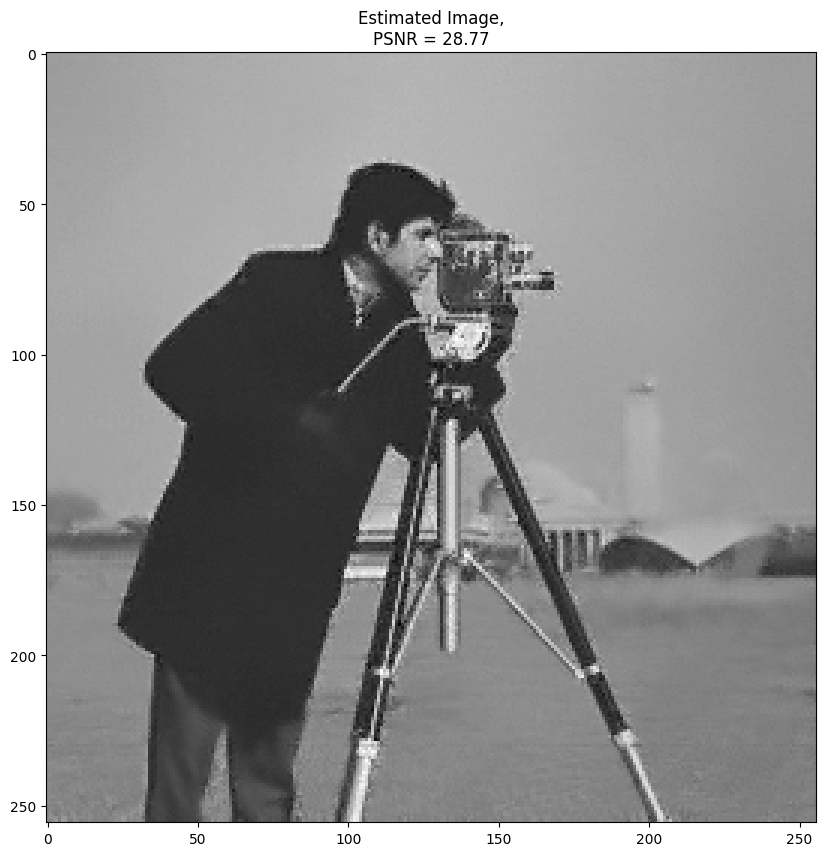

In [12]:
mse = np.mean((img-img_hat)**2)
psnr_hat = 10*np.log10(1/mse)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
